# Skill Recommendation System - Complete Pipeline

This notebook runs the full pipeline:
1. Environment setup and folder creation
2. Data download (O*NET automatic, ESCO manual)
3. Import into SQLite databases
4. WALS model training (ESCO; O*NET: task model + technology skill model)
5. **Position-based recommendations**: given a position (input tasks, skills, or technologies), recommend related tasks, knowledge/skills, or technology skills, with visualizations

O*NET is based on two tables: **tasks** (occupation x task with IM importance) and **technology skills** (occupation x software/tool with derived weight). Recommendations are computed from the position embedding (average of input item embeddings).

---

## 1. Setup and Import

In [6]:
import os
import sys
import logging
import urllib.request
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Add src to path
project_root = Path.cwd()
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

Project root: /home/luca/projects/skill_recommendation


## 2. Create Folders

In [7]:
# Create necessary folders
folders = ['data', 'models', 'outputs']

for folder in folders:
    folder_path = project_root / folder
    folder_path.mkdir(exist_ok=True)
    print(f" Folder created/existing: {folder_path}")

 Folder created/existing: /home/luca/projects/skill_recommendation/data
 Folder created/existing: /home/luca/projects/skill_recommendation/models
 Folder created/existing: /home/luca/projects/skill_recommendation/outputs


## 3. Download Data

### 3.1 Download O*NET (Automatic)

In [8]:
# Download O*NET database
onet_url = "https://www.onetcenter.org/dl_files/database/db_30_1_text.zip"
onet_zip_path = project_root / "data" / "db_30_1_text.zip"

if onet_zip_path.exists():
    print(f" O*NET file already present: {onet_zip_path}")
    print(f"  Size: {onet_zip_path.stat().st_size / (1024*1024):.2f} MB")
else:
    print(f"Downloading O*NET from: {onet_url}")
    print("This may take a few minutes...")
    
    def show_progress(block_num, block_size, total_size):
        downloaded = block_num * block_size
        percent = min(downloaded * 100 / total_size, 100)
        print(f"\rProgress: {percent:.1f}% ({downloaded / (1024*1024):.1f} MB / {total_size / (1024*1024):.1f} MB)", end="")
    
    try:
        urllib.request.urlretrieve(onet_url, onet_zip_path, show_progress)
        print("\n O*NET download completed!")
    except Exception as e:
        print(f"\n Error during download: {e}")
        raise

 O*NET file already present: /home/luca/projects/skill_recommendation/data/db_30_1_text.zip
  Size: 12.81 MB


### 3.2 Download ESCO (Manual)

**IMPORTANT**: ESCO download requires manual interaction because the website requires:
1. Acceptance of terms of use
2. Language selection
3. Manual ZIP file download

**Instructions:**
1. Go to: https://esco.ec.europa.eu/en/use-esco/download
2. Accept the terms and select language (e.g., English)
3. Download the file `classification_en.zip` (or other language)
4. Copy the file to the `data/` folder with the name `esco_classification_en.zip`

**After manually downloading, run the following cell to verify:**

In [9]:
# Verify ESCO file presence
esco_zip_path = project_root / "data" / "esco_classification_en.zip"

if esco_zip_path.exists():
    print(f" ESCO file found: {esco_zip_path}")
    print(f"  Size: {esco_zip_path.stat().st_size / (1024*1024):.2f} MB")
else:
    print(" ESCO file not found!")
    print(f"\nPlease manually download the file from:")
    print("https://esco.ec.europa.eu/en/use-esco/download")
    print(f"\nAnd save it as: {esco_zip_path}")
    print("\nThen re-run this cell to verify.")

 ESCO file found: /home/luca/projects/skill_recommendation/data/esco_classification_en.zip
  Size: 9.58 MB


## 4. Import Data into Databases

### 4.1 Import O*NET (occupations, tasks, technology skills)

In [ ]:
# Import O*NET (occupations, tasks from Task Statements + Task Ratings IM, technology skills)
import subprocess

onet_db_path = project_root / "data" / "onet.db"

if not onet_zip_path.exists():
    print(" O*NET file not found! Run the download first.")
else:
    print("Importing O*NET database (tasks + technology skills)...")
    result = subprocess.run(
        [
            sys.executable,
            str(project_root / "scripts" / "import_onet.py"),
            "--zip_path", str(onet_zip_path),
            "--db_path", str(onet_db_path),
            "--recreate",
        ],
        cwd=str(project_root),
        capture_output=False,
    )
    if result.returncode != 0:
        raise RuntimeError("Import O*NET fallito")
    print(f"\n O*NET database created: {onet_db_path}")

Importing O*NET database (tasks + technology skills)...


[2026-01-29 00:18:47,063] INFO - Removing existing database: /home/luca/projects/skill_recommendation/data/onet.db
[2026-01-29 00:18:47,065] INFO - Creating database: /home/luca/projects/skill_recommendation/data/onet.db
[2026-01-29 00:18:47,099] INFO - Database created: /home/luca/projects/skill_recommendation/data/onet.db
[2026-01-29 00:18:47,100] INFO - Extracting /home/luca/projects/skill_recommendation/data/db_30_1_text.zip...
[2026-01-29 00:18:47,492] INFO - Importing occupations...
[2026-01-29 00:18:47,500] INFO -   Processing occupation 1000...
[2026-01-29 00:18:47,512] INFO -   1016 created, 0 updated
[2026-01-29 00:18:47,512] INFO - Importing tasks (Task Statements)...
[2026-01-29 00:18:47,552] INFO -   Processing task statement 5000...
[2026-01-29 00:18:47,583] INFO -   Processing task statement 10000...
[2026-01-29 00:18:47,626] INFO -   Processing task statement 15000...
[2026-01-29 00:18:47,680] INFO -   18796 created, 0 updated
[2026-01-29 00:18:47,680] INFO - Importing 


 O*NET database created: /home/luca/projects/skill_recommendation/data/onet.db


[2026-01-29 00:18:48,391] INFO -   Processing occupation-tech skill 30000...
[2026-01-29 00:18:48,455] INFO -   32773 relations created
[2026-01-29 00:18:48,487] INFO - 
[2026-01-29 00:18:48,487] INFO - IMPORT COMPLETE - Summary
[2026-01-29 00:18:48,487] INFO - ============================================================
[2026-01-29 00:18:48,487] INFO - Occupations: 1016 created, 0 updated
[2026-01-29 00:18:48,487] INFO - Tasks: 18796 created, 0 updated
[2026-01-29 00:18:48,487] INFO - Occupation-task ratings (IM): 17951
[2026-01-29 00:18:48,487] INFO - Technology skills: 8785 created, 0 updated
[2026-01-29 00:18:48,487] INFO - Occupation-technology_skill relations: 32773
[2026-01-29 00:18:48,487] INFO - ============================================================


### 4.2 Import ESCO

In [11]:
# Import ESCO
import tempfile
import zipfile
from scripts.import_esco import create_database, import_occupations, import_skills, import_relations

esco_db_path = project_root / "data" / "esco.db"
language = 'en'  # Edit if necessary

if not esco_zip_path.exists():
    print(" ESCO file not found! Manually download the file.")
else:
    print(f"Importing ESCO database (language: {language})...")
    
    # Create database
    if not esco_db_path.exists():
        create_database(str(esco_db_path))
    
    # Extract ZIP
    with tempfile.TemporaryDirectory() as temp_dir:
        with zipfile.ZipFile(esco_zip_path, 'r') as zip_ref:
            zip_ref.extractall(temp_dir)
        
        # Find necessary CSV files
        temp_path = Path(temp_dir)
        occupation_file = None
        skills_file = None
        relations_file = None
        
        for file in temp_path.rglob(f"occupations_{language}.csv"):
            occupation_file = file
            break
        
        for file in temp_path.rglob(f"skills_{language}.csv"):
            skills_file = file
            break
        
        for file in temp_path.rglob(f"occupationSkillRelations_{language}.csv"):
            relations_file = file
            break
        
        if not occupation_file or not skills_file or not relations_file:
            print(" Required CSV files not found in ZIP")
            print(f"   Cercati: occupations_{language}.csv, skills_{language}.csv, occupationSkillRelations_{language}.csv")
        else:
            conn = sqlite3.connect(str(esco_db_path))
            cursor = conn.cursor()
            
            try:
                print("  Import occupazioni...")
                stats_occ = import_occupations(cursor, occupation_file, language)
                print(f"     Occupazioni: {stats_occ['created']} create, {stats_occ['updated']} aggiornate")
                conn.commit()
                
                print("  Import skill...")
                stats_skills = import_skills(cursor, skills_file, language)
                print(f"     Skills: {stats_skills['created']} created, {stats_skills['updated']} updated")
                conn.commit()
                
                print("  Import relazioni occupazione-skill...")
                relations_count = import_relations(cursor, relations_file, language)
                print(f"     Relazioni: {relations_count} create")
                conn.commit()
                
                print(f"\n ESCO database created: {esco_db_path}")
            except Exception as e:
                conn.rollback()
                print(f" Errore durante l'import: {e}")
                raise
            finally:
                conn.close()

Importing ESCO database (language: en)...
  Import occupazioni...
     Occupazioni: 0 create, 3043 aggiornate
  Import skill...


[2026-01-29 00:18:49,017] INFO -   Processing skill 10000...
[2026-01-29 00:18:49,251] INFO -   Processing relation 10000...
[2026-01-29 00:18:49,298] INFO -   Processing relation 20000...


     Skills: 0 created, 13960 updated
  Import relazioni occupazione-skill...


[2026-01-29 00:18:49,347] INFO -   Processing relation 30000...
[2026-01-29 00:18:49,398] INFO -   Processing relation 40000...
[2026-01-29 00:18:49,451] INFO -   Processing relation 50000...
[2026-01-29 00:18:49,503] INFO -   Processing relation 60000...
[2026-01-29 00:18:49,551] INFO -   Processing relation 70000...
[2026-01-29 00:18:49,596] INFO -   Processing relation 80000...
[2026-01-29 00:18:49,643] INFO -   Processing relation 90000...
[2026-01-29 00:18:49,690] INFO -   Processing relation 100000...
[2026-01-29 00:18:49,736] INFO -   Processing relation 110000...
[2026-01-29 00:18:49,788] INFO -   Processing relation 120000...


     Relazioni: 0 create

 ESCO database created: /home/luca/projects/skill_recommendation/data/esco.db


## 5. Model Training

### 5.1 O*NET Hyperparameter search

Split 90/10 train/val, grid search over factors, regularization, iterations, w_0; evaluate on held-out RMSE. Run this section to get `best_params_task` and `best_params_tech`; optionally use them in the training cell below or in the "Train final model with best params" cell.

In [12]:
from src.onet_hyperparameter_search import grid_search_onet_task, grid_search_onet_tech_skill
import pandas as pd

# Param grid: factors, regularization, iterations, w_0 (2×2×3×3 = 36 runs per model)
# iterations: 10–20 usually sufficient for WALS; w_0 = weight for unobserved entries
param_grid = {
    "factors": [50, 100],
    "regularization": [0.01, 0.1],
    "iterations": [10, 15, 20],
    "w_0": [0.01, 0.05, 0.1],
}

In [13]:
if onet_db_path.exists():
    results_task, best_params_task = grid_search_onet_task(
        str(onet_db_path), param_grid, val_frac=0.1, metric="rmse", verbose=1
    )
    df_task = pd.DataFrame([
        {**r["params"], "val_rmse": r["val_metric"], "time_s": r["time"]}
        for r in results_task
    ])
    display(df_task)
else:
    print("O*NET database not found. Run import first.")

[2026-01-29 00:18:50,237] INFO - Loading ONET task data from /home/luca/projects/skill_recommendation/data/onet.db
[2026-01-29 00:18:50,240] INFO - Loaded 1016 occupations
[2026-01-29 00:18:50,262] INFO - Loaded 18796 tasks
[2026-01-29 00:18:50,286] INFO - Loaded 17951 occupation-task relations (IM importance)
[2026-01-29 00:18:50,290] INFO - O*NET task: 16156 train, 1795 val relations
[2026-01-29 00:18:50,298] INFO - Built sparse matrix: (1016, 18796), 16156 non-zero entries
[2026-01-29 00:19:23,294] INFO -   params {'factors': 50, 'regularization': 0.01, 'iterations': 10, 'w_0': 0.01} -> val_metric=1.000000 time=33.0s
[2026-01-29 00:19:23,303] INFO - Built sparse matrix: (1016, 18796), 16156 non-zero entries
[2026-01-29 00:19:57,965] INFO -   params {'factors': 50, 'regularization': 0.01, 'iterations': 10, 'w_0': 0.05} -> val_metric=1.000000 time=34.7s
[2026-01-29 00:19:57,973] INFO - Built sparse matrix: (1016, 18796), 16156 non-zero entries
[2026-01-29 00:20:31,101] INFO -   params

,factors,regularization,iterations,w_0,val_rmse,time_s
0,50,0.01,10,0.01,1.0,33.004025
1,50,0.01,10,0.05,1.0,34.670524
2,50,0.01,10,0.10,1.0,33.135075
3,50,0.01,15,0.01,1.0,55.148951
4,50,0.01,15,0.05,1.0,43.879715
5,50,0.01,15,0.10,1.0,48.838935
6,50,0.01,20,0.01,1.0,66.094576
7,50,0.01,20,0.05,1.0,65.198159
8,50,0.01,20,0.10,1.0,68.298115
9,50,0.10,10,0.01,1.0,34.646696


In [14]:

if onet_db_path.exists():
    results_tech, best_params_tech = grid_search_onet_tech_skill(
        str(onet_db_path), param_grid, val_frac=0.1, metric="rmse", verbose=1
    )
    df_tech = pd.DataFrame([
        {**r["params"], "val_rmse": r["val_metric"], "time_s": r["time"]}
        for r in results_tech
    ])
    display(df_tech)
else:
    print("O*NET database not found. Run import first.")

[2026-01-29 00:56:13,299] INFO - Loading ONET technology skill data from /home/luca/projects/skill_recommendation/data/onet.db


[2026-01-29 00:56:13,309] INFO - Loaded 1016 occupations
[2026-01-29 00:56:13,322] INFO - Loaded 8785 technology skills
[2026-01-29 00:56:13,380] INFO - Loaded 32773 occupation-technology_skill relations
[2026-01-29 00:56:13,390] INFO - O*NET tech skill: 29496 train, 3277 val relations
[2026-01-29 00:56:13,415] INFO - Built sparse matrix: (1016, 8785), 29496 non-zero entries
[2026-01-29 00:56:34,463] INFO -   params {'factors': 50, 'regularization': 0.01, 'iterations': 10, 'w_0': 0.01} -> val_metric=0.636581 time=21.1s
[2026-01-29 00:56:34,478] INFO - Built sparse matrix: (1016, 8785), 29496 non-zero entries
[2026-01-29 00:56:55,112] INFO -   params {'factors': 50, 'regularization': 0.01, 'iterations': 10, 'w_0': 0.05} -> val_metric=0.671533 time=20.6s
[2026-01-29 00:56:55,125] INFO - Built sparse matrix: (1016, 8785), 29496 non-zero entries
[2026-01-29 00:57:16,334] INFO -   params {'factors': 50, 'regularization': 0.01, 'iterations': 10, 'w_0': 0.1} -> val_metric=0.715714 time=21.2s


,factors,regularization,iterations,w_0,val_rmse,time_s
0,50,0.01,10,0.01,0.636581,21.071770
1,50,0.01,10,0.05,0.671533,20.648016
2,50,0.01,10,0.10,0.715714,21.221196
3,50,0.01,15,0.01,0.640049,30.697369
4,50,0.01,15,0.05,0.674757,31.140115
5,50,0.01,15,0.10,0.721176,31.211349
6,50,0.01,20,0.01,0.640784,41.181346
7,50,0.01,20,0.05,0.676349,40.957631
8,50,0.01,20,0.10,0.723827,41.075188
9,50,0.10,10,0.01,0.628750,20.345110


In [15]:
# Best params from grid search (use in "Train final model with best params" below)
if "best_params_task" in dir() and "best_params_tech" in dir():
    print("Best params (task):", best_params_task)
    print("Best params (tech skill):", best_params_tech)
else:
    print("Run the grid search cells above first to get best_params_task and best_params_tech.")

Best params (task): {'factors': 50, 'regularization': 0.01, 'iterations': 10, 'w_0': 0.01}
Best params (tech skill): {'factors': 50, 'regularization': 0.1, 'iterations': 10, 'w_0': 0.01}


### 5.2 O*NET models (task + technology skill)

Two separate WALS models are trained: one for occupation × task (IM importance from Task Ratings) and one for occupation × technology skill (derived weight from Hot Technology / In Demand). Each produces a .pkl file used for position-based recommendations. **If you ran the grid search above, training uses the best params automatically; otherwise default params are used.**

In [16]:
# Uses best_params from grid search when available; otherwise default params
from src.trainer import train_onet_task_model, train_onet_technology_skill_model
import time

models_dir = project_root / "models"
default_params = {"factors": 50, "regularization": 0.1, "iterations": 15, "w_0": 0.01}
params_task = best_params_task if "best_params_task" in dir() else default_params
params_tech = best_params_tech if "best_params_tech" in dir() else default_params

if not onet_db_path.exists():
    print(" O*NET database not found! Run the import first.")
else:
    print("Training O*NET task model...")
    print("Parameters:", params_task)
    result_task = train_onet_task_model(
        db_path=str(onet_db_path),
        output_dir=str(models_dir),
        save_history=True,
        **params_task,
    )
    onet_task_model_path = result_task["model_path"]
    print(f"  Model saved: {onet_task_model_path} ({result_task['total_time']:.2f}s)")

    print("\nTraining O*NET technology skill model...")
    print("Parameters:", params_tech)
    result_tech = train_onet_technology_skill_model(
        db_path=str(onet_db_path),
        output_dir=str(models_dir),
        save_history=True,
        **params_tech,
    )
    onet_tech_skill_model_path = result_tech["model_path"]
    print(f"  Model saved: {onet_tech_skill_model_path} ({result_tech['total_time']:.2f}s)")
    print("\n Training completed!")

[2026-01-29 01:20:39,245] INFO - Loading ONET task data from /home/luca/projects/skill_recommendation/data/onet.db
[2026-01-29 01:20:39,250] INFO - Loaded 1016 occupations
[2026-01-29 01:20:39,282] INFO - Loaded 18796 tasks
[2026-01-29 01:20:39,312] INFO - Loaded 17951 occupation-task relations (IM importance)
[2026-01-29 01:20:39,323] INFO - Built sparse matrix: (1016, 18796), 17951 non-zero entries
[2026-01-29 01:20:39,325] INFO - Task importance: avg=3.9943, range [1.4400, 5.0000]
[2026-01-29 01:20:39,346] INFO - Starting Weighted WALS training: 1016 occupations × 18796 skills, 50 factors


Training O*NET task model...
Parameters: {'factors': 50, 'regularization': 0.01, 'iterations': 10, 'w_0': 0.01}


[2026-01-29 01:20:39,560] INFO - Initial error: 71950.567817
[2026-01-29 01:20:43,172] INFO - Iteration 1/10, error: 127.131028, reduction: 71823.44 (0.18% of initial)
[2026-01-29 01:20:46,513] INFO - Iteration 2/10, error: 122.860143, reduction: 71827.71 (0.17% of initial)
[2026-01-29 01:20:43,847] INFO - Iteration 3/10, error: 120.921269, reduction: 71829.65 (0.17% of initial)
[2026-01-29 01:20:47,367] INFO - Iteration 4/10, error: 119.884828, reduction: 71830.68 (0.17% of initial)
[2026-01-29 01:20:56,190] INFO - Iteration 5/10, error: 119.267697, reduction: 71831.30 (0.17% of initial)
[2026-01-29 01:20:59,406] INFO - Iteration 6/10, error: 118.897340, reduction: 71831.67 (0.17% of initial)
[2026-01-29 01:21:02,739] INFO - Iteration 7/10, error: 118.641375, reduction: 71831.93 (0.16% of initial)
[2026-01-29 01:21:06,005] INFO - Iteration 8/10, error: 118.475299, reduction: 71832.09 (0.16% of initial)
[2026-01-29 01:21:09,304] INFO - Iteration 9/10, error: 118.342980, reduction: 7183

  Model saved: /home/luca/projects/skill_recommendation/models/onet_task_wmf_model.pkl (28.43s)

Training O*NET technology skill model...
Parameters: {'factors': 50, 'regularization': 0.1, 'iterations': 10, 'w_0': 0.01}


[2026-01-29 01:21:08,307] INFO - Loaded 32773 occupation-technology_skill relations
[2026-01-29 01:21:08,327] INFO - Built sparse matrix: (1016, 8785), 32773 non-zero entries
[2026-01-29 01:21:08,330] INFO - Tech skill weight: avg=0.6807, range [0.5000, 1.0000]
[2026-01-29 01:21:08,338] INFO - Starting Weighted WALS training: 1016 occupations × 8785 skills, 50 factors
[2026-01-29 01:21:08,475] INFO - Initial error: 22422.449832
[2026-01-29 01:21:10,549] INFO - Iteration 1/10, error: 760.441986, reduction: 21662.01 (3.39% of initial)
[2026-01-29 01:21:12,745] INFO - Iteration 2/10, error: 342.417430, reduction: 22080.03 (1.53% of initial)
[2026-01-29 01:21:14,825] INFO - Iteration 3/10, error: 300.204724, reduction: 22122.25 (1.34% of initial)
[2026-01-29 01:21:17,169] INFO - Iteration 4/10, error: 282.496291, reduction: 22139.95 (1.26% of initial)
[2026-01-29 01:21:19,298] INFO - Iteration 5/10, error: 272.808588, reduction: 22149.64 (1.22% of initial)
[2026-01-29 01:21:21,525] INFO - 

  Model saved: /home/luca/projects/skill_recommendation/models/onet_tech_skill_wmf_model.pkl (27.05s)

 Training completed!


In [17]:
# Training above uses best_params from grid search automatically when that section was run; otherwise defaults.

### 5.3 ESCO model

Single WALS model on occupation × skill (binary relations). Used for position-based skill recommendations.

In [18]:
from src.trainer import train_esco_model

if not esco_db_path.exists():
    print(" ESCO database not found! Run the import first.")
else:
    print("Training ESCO model...")
    print("Parameters: factors=50, regularization=0.1, iterations=15")
    
    start_time = time.time()
    
    result = train_esco_model(
        db_path=str(esco_db_path),
        output_dir=str(models_dir),
        language='en',
        factors=50,
        regularization=0.1,
        iterations=15,
        w_0=0.01,
        save_history=True
    )
    
    elapsed_time = time.time() - start_time
    
    print(f"\n Training completed!")
    print(f"  Model saved: {result['model_path']}")
    print(f"  Tempo totale: {result['total_time']:.2f} secondi ({result['total_time']/60:.2f} minuti)")
    
    if result.get('initial_error') and result.get('final_error'):
        error_reduction = result['initial_error'] - result['final_error']
        reduction_pct = (error_reduction / result['initial_error']) * 100
        print(f"  Riduzione errore: {error_reduction:.2f} ({reduction_pct:.2f}%)")
    
    esco_model_path = result['model_path']

[2026-01-29 01:21:35,441] INFO - Loading ESCO data from /home/luca/projects/skill_recommendation/data/esco.db (language=en)
[2026-01-29 01:21:35,454] INFO - Loaded 3039 occupations
[2026-01-29 01:21:35,494] INFO - Loaded 13939 skills


Training ESCO model...
Parameters: factors=50, regularization=0.1, iterations=15


[2026-01-29 01:21:35,914] INFO - Loaded 126051 occupation-skill relations
[2026-01-29 01:21:35,982] INFO - Built sparse matrix: (3039, 13939), 126051 non-zero entries
[2026-01-29 01:21:35,983] INFO - Training WALS model (factors=50, regularization=0.1, iterations=15)
[2026-01-29 01:21:35,998] INFO - Starting WALS training: 3039 occupations × 13939 skills, 50 factors
[2026-01-29 01:21:36,424] INFO - Initial error: 126672.173227
[2026-01-29 01:21:48,533] INFO - Iteration 1/15, error: 7412.620275, reduction: 119259.55 (5.85% of initial)
[2026-01-29 01:21:55,402] INFO - Iteration 2/15, error: 2675.052343, reduction: 123997.12 (2.11% of initial)
[2026-01-29 01:22:12,575] INFO - Iteration 3/15, error: 2182.283489, reduction: 124489.89 (1.72% of initial)
[2026-01-29 01:22:19,378] INFO - Iteration 4/15, error: 2012.058573, reduction: 124660.11 (1.59% of initial)
[2026-01-29 01:22:31,064] INFO - Iteration 5/15, error: 1930.966947, reduction: 124741.21 (1.52% of initial)
[2026-01-29 01:22:43,025


 Training completed!
  Model saved: /home/luca/projects/skill_recommendation/models/esco_wmf_model_en.pkl
  Tempo totale: 177.51 secondi (2.96 minuti)
  Riduzione errore: 124885.79 (98.59%)


## 6. Position-based Recommendations

Recommendations are computed from a **position** defined by input items (e.g. a few tasks or technology skills). The position embedding is the average of those items' embeddings; scores for all items are then ranked to suggest related tasks, skills, or technologies.

### 6.1 Visualization helper

In [19]:
def visualize_recommendations(recommendations, title="Recommendations", top_k=5, skill_id_to_name=None):
    """
    Plot recommendations with scores and horizontal bar chart.
    skill_id_to_name: optional dict mapping id/URI -> descriptive name (for labels and output).
    """
    if not recommendations:
        print("No recommendations available.")
        return

    top_recs = recommendations[:top_k]
    skill_ids = [rec[0] for rec in top_recs]
    scores = [rec[1] for rec in top_recs]

    def display_name(sid):
        return (skill_id_to_name.get(sid, sid) if skill_id_to_name else sid)

    def truncate_label(s, max_len=50):
        if len(s) <= max_len:
            return s
        return s[:(max_len-3)] + '...'

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, max(8, len(top_recs) * 0.4)))
    y_pos = np.arange(len(skill_ids))
    colors = plt.cm.viridis(np.linspace(0, 1, len(skill_ids)))
    bars = ax1.barh(y_pos, scores, color=colors)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([truncate_label(display_name(sid), 50) for sid in skill_ids], fontsize=8)
    ax1.set_xlabel('Score', fontsize=10, fontweight='bold')
    ax1.set_title(f'{title}\n(Top {len(top_recs)})', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, 1)
    ax1.grid(axis='x', alpha=0.3)
    ax1.invert_yaxis()

    for i, (bar, score) in enumerate(zip(bars, scores)):
        width = bar.get_width()
        ax1.text(width, bar.get_y() + bar.get_height()/2,
                f'{score:.4f}', ha='left', va='center', fontsize=7)

    ax2.axis('tight')
    ax2.axis('off')
    table_data = []
    for i, (sid, score) in enumerate(top_recs, 1):
        name = display_name(sid)
        display_val = name[:70] + '...' if len(name) > 70 else name
        table_data.append([i, display_val, f'{score:.4f}'])
    table = ax2.table(cellText=table_data,
                     colLabels=['Pos.', 'Skill / Task / Tech', 'Score'],
                     cellLoc='left',
                     loc='center',
                     colWidths=[0.1, 0.7, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    for i in range(3):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}")
    print(f"\nTop {len(top_recs)} recommendations:\n")
    for i, (sid, score) in enumerate(top_recs, 1):
        print(f"{i:3d}. Score: {score:8.4f} | {display_name(sid)}")

### 6.2 O*NET - Task and technology skill recommendations (position-based)

[2026-01-29 01:24:33,604] INFO - Model loaded from: /home/luca/projects/skill_recommendation/models/onet_task_wmf_model.pkl
[2026-01-29 01:24:33,604] INFO -   - Factors: 50
[2026-01-29 01:24:33,605] INFO -   - Matrix shape: (1016, 18796)
[2026-01-29 01:24:33,626] INFO - Built position embedding from 6 skills
[2026-01-29 01:24:33,634] INFO - Generated 5 recommendations
[2026-01-29 01:24:33,639] INFO -   - Top score: 0.0340
[2026-01-29 01:24:33,639] INFO -   - Bottom score: 0.0339


Loading O*NET task model...

Input tasks (random sample, n=6):
  9902 — String cables through pulleys and blocks....
  16331 — Conduct water quality studies to identify and characterize w...
  12234 — Trim, smooth, and shape surfaces, and plane, shave, file, sc...
  5472 — Collaborate with research workers in other disciplines....
  23971 — Research the target audience of projects....
  10912 — Teach physics to students....


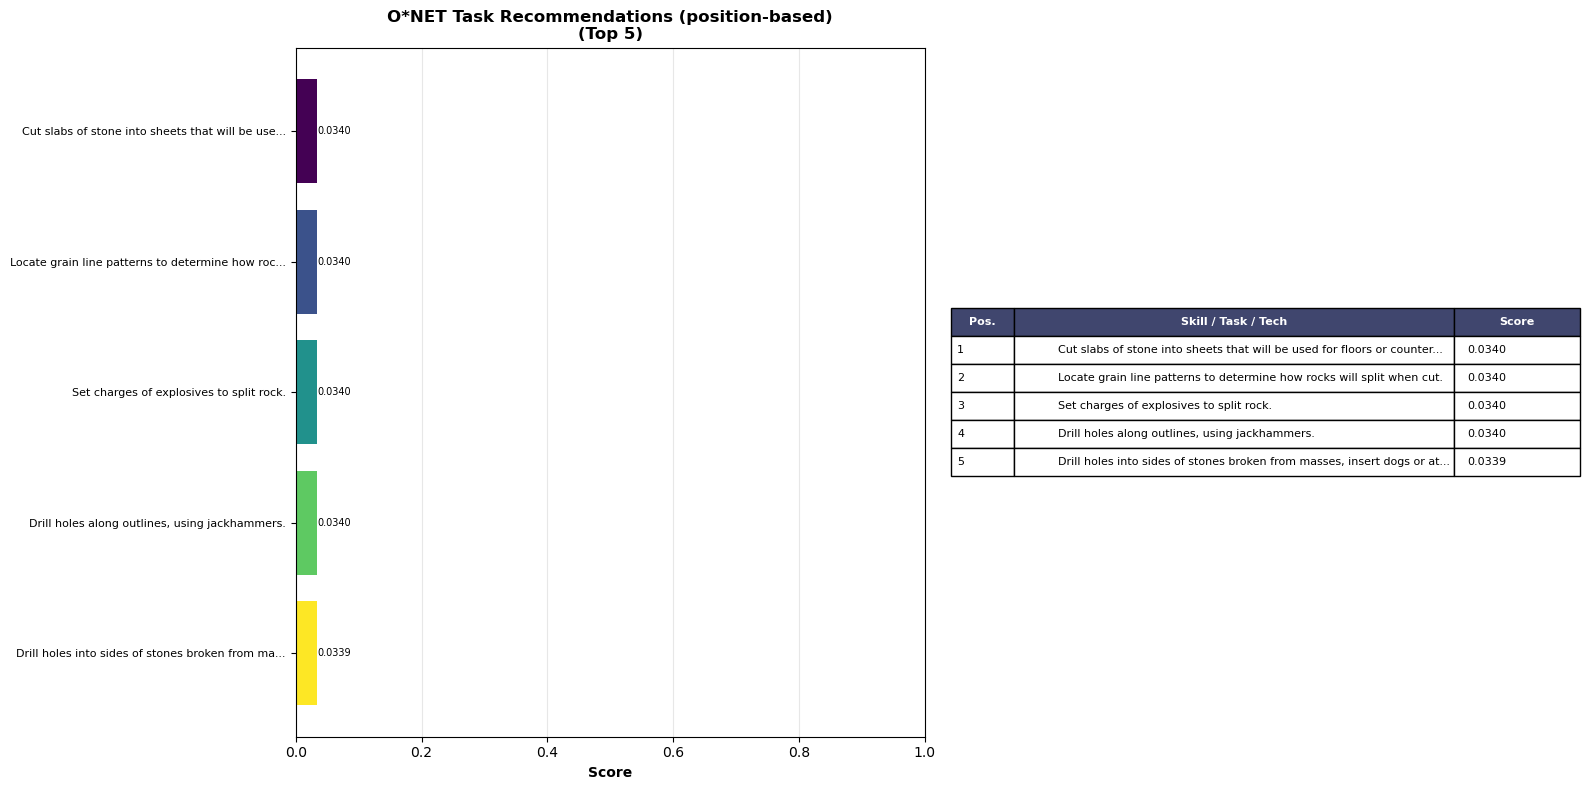

[2026-01-29 01:24:33,901] INFO - Model loaded from: /home/luca/projects/skill_recommendation/models/onet_tech_skill_wmf_model.pkl
[2026-01-29 01:24:33,902] INFO -   - Factors: 50
[2026-01-29 01:24:33,902] INFO -   - Matrix shape: (1016, 8785)
[2026-01-29 01:24:33,909] INFO - Built position embedding from 5 skills
[2026-01-29 01:24:33,913] INFO - Generated 5 recommendations
[2026-01-29 01:24:33,913] INFO -   - Top score: 0.1516
[2026-01-29 01:24:33,914] INFO -   - Bottom score: 0.1141



O*NET Task Recommendations (position-based)

Top 5 recommendations:

  1. Score:   0.0340 | Cut slabs of stone into sheets that will be used for floors or counters.
  2. Score:   0.0340 | Locate grain line patterns to determine how rocks will split when cut.
  3. Score:   0.0340 | Set charges of explosives to split rock.
  4. Score:   0.0340 | Drill holes along outlines, using jackhammers.
  5. Score:   0.0339 | Drill holes into sides of stones broken from masses, insert dogs or attach sling

Loading O*NET technology skill model...

Input technology skills (random sample, n=5): ['Voice over internet protocol VoIP system software', 'Lattice MediCopia', 'QSR International NVivo', 'PEB XLDent', 'ESSA Technologies Path Landscape Model']


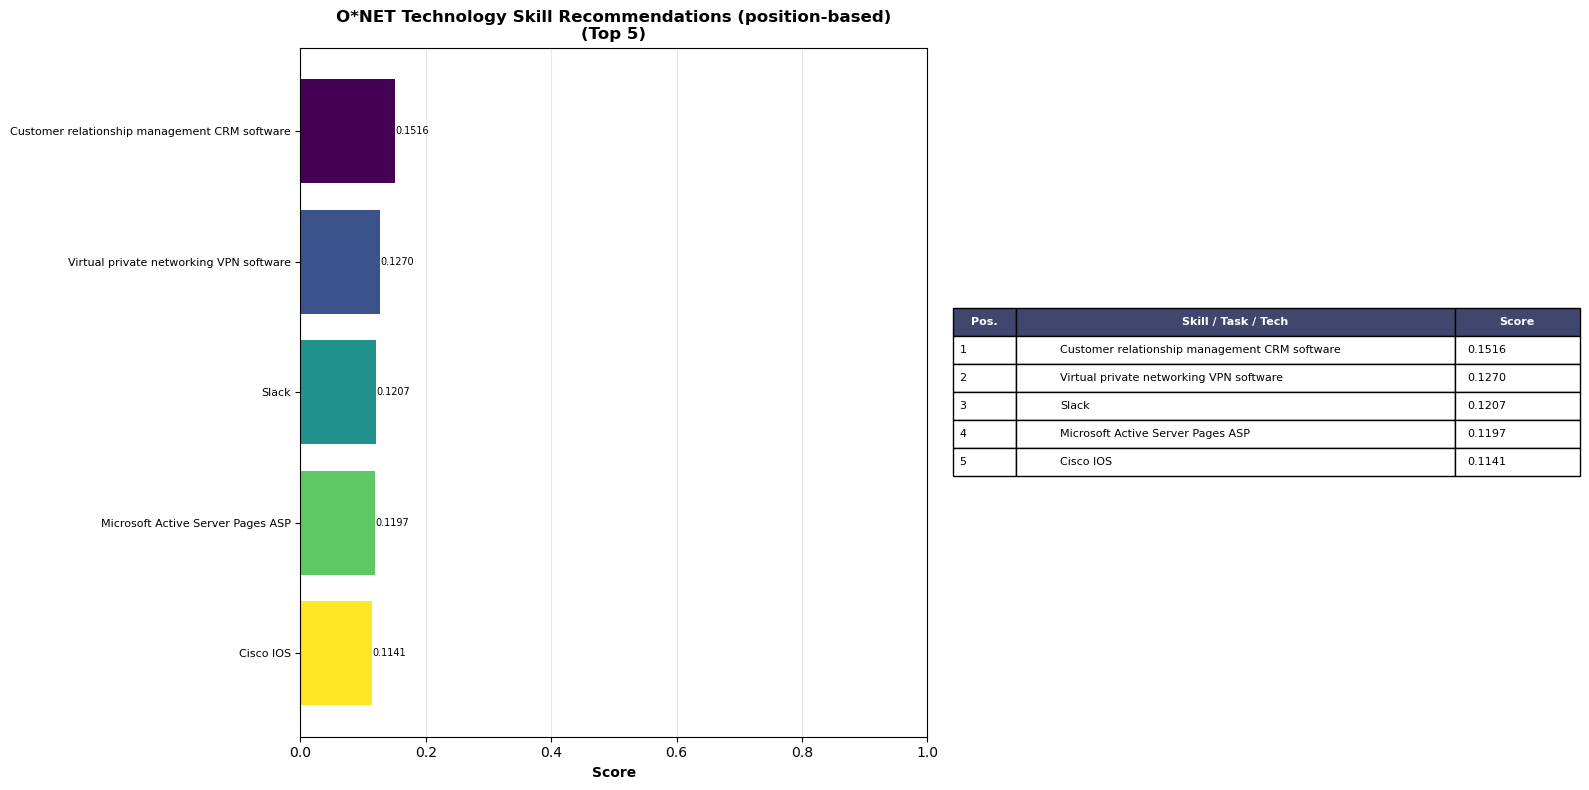


O*NET Technology Skill Recommendations (position-based)

Top 5 recommendations:

  1. Score:   0.1516 | Customer relationship management CRM software
  2. Score:   0.1270 | Virtual private networking VPN software
  3. Score:   0.1207 | Slack
  4. Score:   0.1197 | Microsoft Active Server Pages ASP
  5. Score:   0.1141 | Cisco IOS


In [20]:
from src.recommender import load_model, recommend_skills
import random
import sqlite3

conn = sqlite3.connect(str(onet_db_path))
cursor = conn.cursor()

# --- O*NET Task model (position = input tasks) ---
onet_task_model_path = project_root / "models" / "onet_task_wmf_model.pkl"
if not Path(onet_task_model_path).exists():
    print(" O*NET task model not found! Run training first.")
else:
    print("Loading O*NET task model...")
    onet_task_model = load_model(str(onet_task_model_path))
    cursor.execute("SELECT task_id, task_text FROM onet_task")
    task_id_to_name = {row[0]: (row[1] or row[0])[:80] for row in cursor.fetchall()}
    n_input = random.randint(3, 7)
    cursor.execute("""
        SELECT t.task_id FROM onet_occupation_task rel
        INNER JOIN onet_task t ON rel.task_id = t.id
        GROUP BY t.task_id ORDER BY RANDOM() LIMIT ?
    """, (n_input,))
    input_tasks = [row[0] for row in cursor.fetchall()]
    print(f"\nInput tasks (random sample, n={len(input_tasks)}):")
    for tid in input_tasks:
        print(f"  {tid} — {task_id_to_name.get(tid, '?')[:60]}...")
    onet_task_recommendations = recommend_skills(
        model_data=onet_task_model,
        input_skill_uris=input_tasks,
        top_k=5,
        filter_existing=True
    )
    visualize_recommendations(
        onet_task_recommendations,
        title="O*NET Task Recommendations (position-based)",
        top_k=5,
        skill_id_to_name=task_id_to_name
    )

# --- O*NET Technology Skill model (position = input technologies) ---
onet_tech_skill_model_path = project_root / "models" / "onet_tech_skill_wmf_model.pkl"
if not Path(onet_tech_skill_model_path).exists():
    print("\n O*NET technology skill model not found! Run training first.")
else:
    print("\nLoading O*NET technology skill model...")
    onet_tech_skill_model = load_model(str(onet_tech_skill_model_path))
    cursor.execute("SELECT example FROM onet_technology_skill")
    tech_skill_id_to_name = {row[0]: row[0] for row in cursor.fetchall()}
    cursor.execute("SELECT example FROM onet_technology_skill ORDER BY RANDOM() LIMIT 5")
    input_tech = [row[0] for row in cursor.fetchall()]
    print(f"\nInput technology skills (random sample, n={len(input_tech)}): {input_tech}")
    onet_tech_recommendations = recommend_skills(
        model_data=onet_tech_skill_model,
        input_skill_uris=input_tech,
        top_k=5,
        filter_existing=True
    )
    visualize_recommendations(
        onet_tech_recommendations,
        title="O*NET Technology Skill Recommendations (position-based)",
        top_k=5,
        skill_id_to_name=tech_skill_id_to_name
    )

conn.close()

### 6.3 ESCO recommendations (position-based on input skills)

[2026-01-29 01:24:34,070] INFO - Model loaded from: /home/luca/projects/skill_recommendation/models/esco_wmf_model_en.pkl
[2026-01-29 01:24:34,072] INFO -   - Factors: 50
[2026-01-29 01:24:34,072] INFO -   - Matrix shape: (3039, 13939)


Loading ESCO model...


[2026-01-29 01:24:34,179] INFO - Built position embedding from 4 skills
[2026-01-29 01:24:34,187] INFO - Generated 5 recommendations
[2026-01-29 01:24:34,193] INFO -   - Top score: 0.1765
[2026-01-29 01:24:34,193] INFO -   - Bottom score: 0.1481



Skill in input (campione casuale, n=4):
  mix terrazzo material
  perform minor vehicle repairs
  assemble cameras
  take measures against flammability

Generating ESCO recommendations...


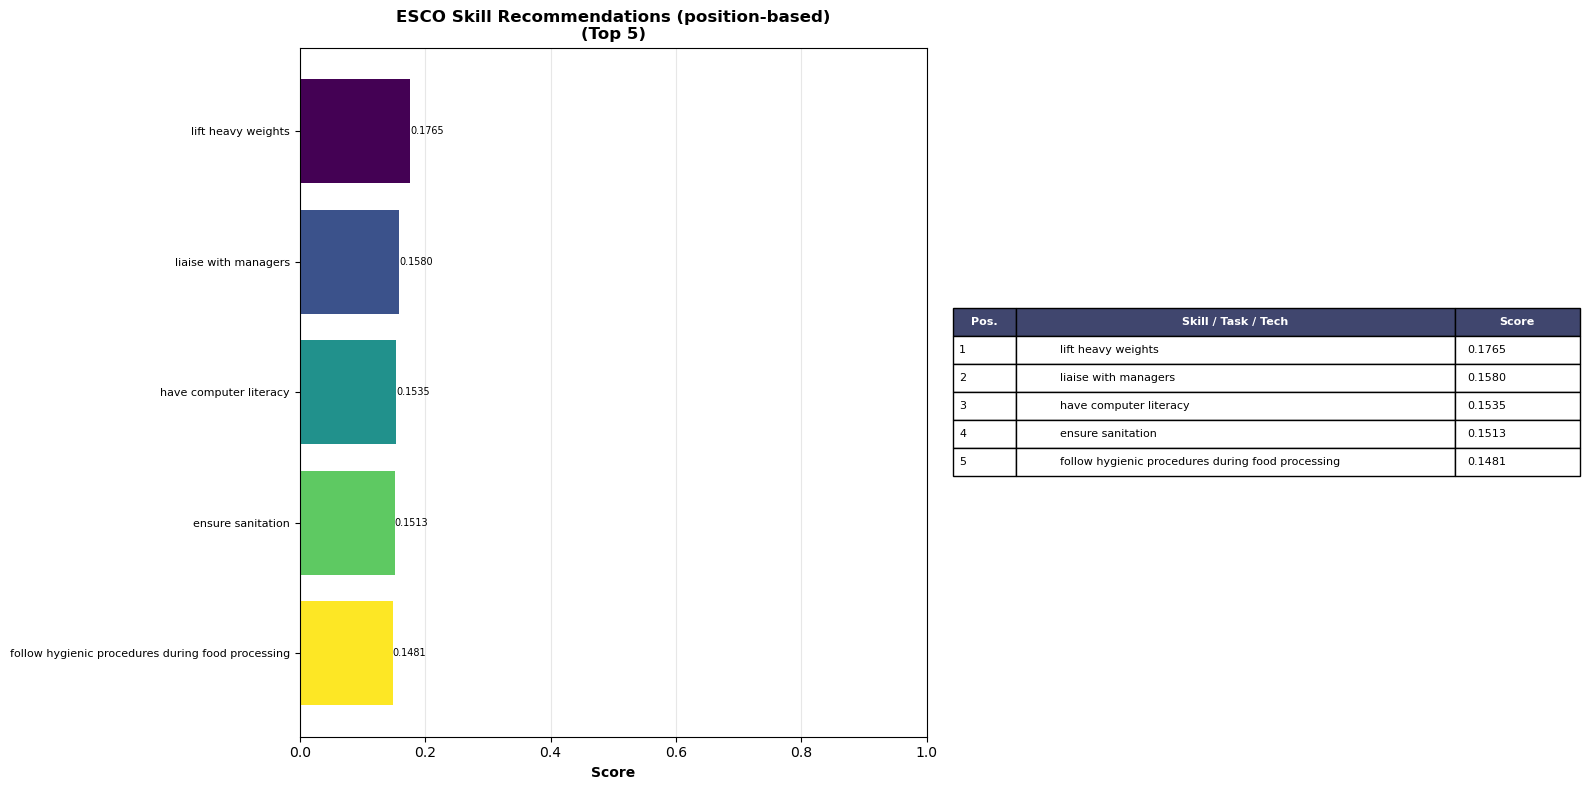


ESCO Skill Recommendations (position-based)

Top 5 recommendations:

  1. Score:   0.1765 | lift heavy weights
  2. Score:   0.1580 | liaise with managers
  3. Score:   0.1535 | have computer literacy
  4. Score:   0.1513 | ensure sanitation
  5. Score:   0.1481 | follow hygienic procedures during food processing


In [21]:
import random

# Load ESCO model (position = input skill URIs)
if 'esco_model_path' not in locals():
    esco_model_path = project_root / "models" / "esco_wmf_model_en.pkl"

if not Path(esco_model_path).exists():
    print(" ESCO model not found! Run training first.")
else:
    print("Loading ESCO model...")
    esco_model = load_model(str(esco_model_path))
    
    # Get some example skill URIs and build uri -> title map
    conn = sqlite3.connect(str(esco_db_path))
    cursor = conn.cursor()
    
    cursor.execute("SELECT uri, title FROM esco_skill WHERE language = 'en'")
    skill_id_to_name = {row[0]: row[1] for row in cursor.fetchall()}
    
    n_input = random.randint(3, 7)
    cursor.execute("""
        SELECT sk.uri
        FROM esco_occupation_skill rel
        INNER JOIN esco_skill sk ON rel.skill_id = sk.id
        WHERE sk.language = 'en'
        GROUP BY sk.uri
        ORDER BY RANDOM()
        LIMIT ?
    """, (n_input,))
    
    input_skills = [row[0] for row in cursor.fetchall()]
    conn.close()
    print(f"\nSkill in input (campione casuale, n={len(input_skills)}):")
    for uri in input_skills:
        print(f"  {skill_id_to_name.get(uri, '?')}")
    
    # Generate recommendations
    print("\nGenerating ESCO recommendations...")
    esco_recommendations = recommend_skills(
        model_data=esco_model,
        input_skill_uris=input_skills,
        top_k=5,
        filter_existing=True
    )
    
    # Visualizza risultati
    visualize_recommendations(
        esco_recommendations,
        title="ESCO Skill Recommendations (position-based)",
        top_k=5,
        skill_id_to_name=skill_id_to_name
    )

## 7. Custom tests

You can try custom skills, tasks, or technologies by editing the following cells (position = your chosen input items):

### 7.1 Custom O*NET (keyword in task text)

Define position by tasks whose text contains a keyword; then get task recommendations.

[2026-01-29 01:24:34,403] INFO - Built position embedding from 4 skills
[2026-01-29 01:24:34,413] INFO - Generated 5 recommendations
[2026-01-29 01:24:34,415] INFO -   - Top score: 0.0271
[2026-01-29 01:24:34,416] INFO -   - Bottom score: 0.0270


Custom O*NET tasks (keyword 'Negotiation', n=4):
  15279 — Represent their parties in negotiations with political execu...
  18840 — Respond to customer complaints, legal inquiries, payment neg...
  15827 — Lead or support negotiations involving tax agreements or aba...
  90 — Establish and maintain tendering process, and conduct negoti...


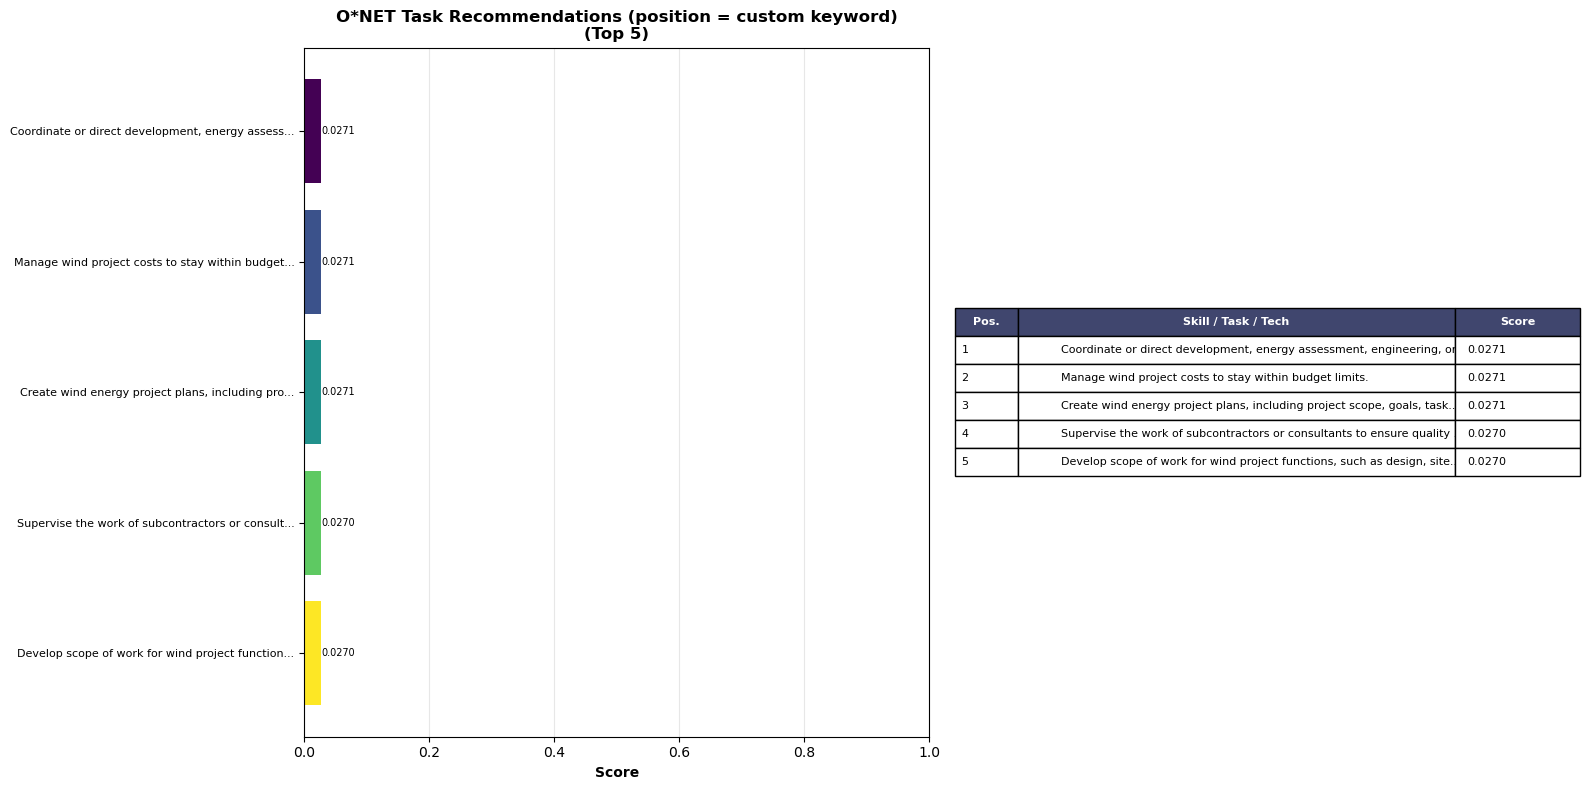


O*NET Task Recommendations (position = custom keyword)

Top 5 recommendations:

  1. Score:   0.0271 | Coordinate or direct development, energy assessment, engineering, or constructio
  2. Score:   0.0271 | Manage wind project costs to stay within budget limits.
  3. Score:   0.0271 | Create wind energy project plans, including project scope, goals, tasks, resourc
  4. Score:   0.0270 | Supervise the work of subcontractors or consultants to ensure quality and confor
  5. Score:   0.0270 | Develop scope of work for wind project functions, such as design, site assessmen


In [22]:
# Custom O*NET: tasks whose text contains a keyword (position = these tasks)
keyword = "Negotiation"

if 'onet_task_model' in locals() and (onet_db_path := project_root / "data" / "onet.db").exists():
    conn = sqlite3.connect(str(onet_db_path))
    cursor = conn.cursor()
    cursor.execute("SELECT task_id, task_text FROM onet_task")
    task_id_to_name = {r[0]: (r[1] or r[0])[:80] for r in cursor.fetchall()}
    cursor.execute("SELECT task_id FROM onet_task WHERE task_text IS NOT NULL AND LOWER(task_text) LIKE ? LIMIT 4", (f"%{keyword}%",))
    custom_task_ids = [r[0] for r in cursor.fetchall()]
    conn.close()
    if custom_task_ids:
        print(f"Custom O*NET tasks (keyword '{keyword}', n={len(custom_task_ids)}):")
        for tid in custom_task_ids:
            print(f"  {tid} — {task_id_to_name.get(tid, '?')[:60]}...")
        custom_recommendations = recommend_skills(
            model_data=onet_task_model,
            input_skill_uris=custom_task_ids,
            top_k=5,
            filter_existing=True
        )
        visualize_recommendations(
            custom_recommendations,
            title="O*NET Task Recommendations (position = custom keyword)",
            top_k=5,
            skill_id_to_name=task_id_to_name
        )
    else:
        print(f"No tasks found with keyword '{keyword}'")
else:
    print("Load the O*NET task model first in section 6.2")


### 7.2 Custom ESCO (keyword in skill title)

Define position by skills whose title contains a keyword; then get skill recommendations.

[2026-01-29 01:24:34,676] INFO - Built position embedding from 4 skills
[2026-01-29 01:24:34,684] INFO - Generated 5 recommendations
[2026-01-29 01:24:34,685] INFO -   - Top score: 0.4034
[2026-01-29 01:24:34,686] INFO -   - Bottom score: 0.3542


Custom ESCO skills (keyword 'garden', n=4):
  build garden masonry
  establish vertical gardens
  use gardening equipment
  maintain gardening equipment


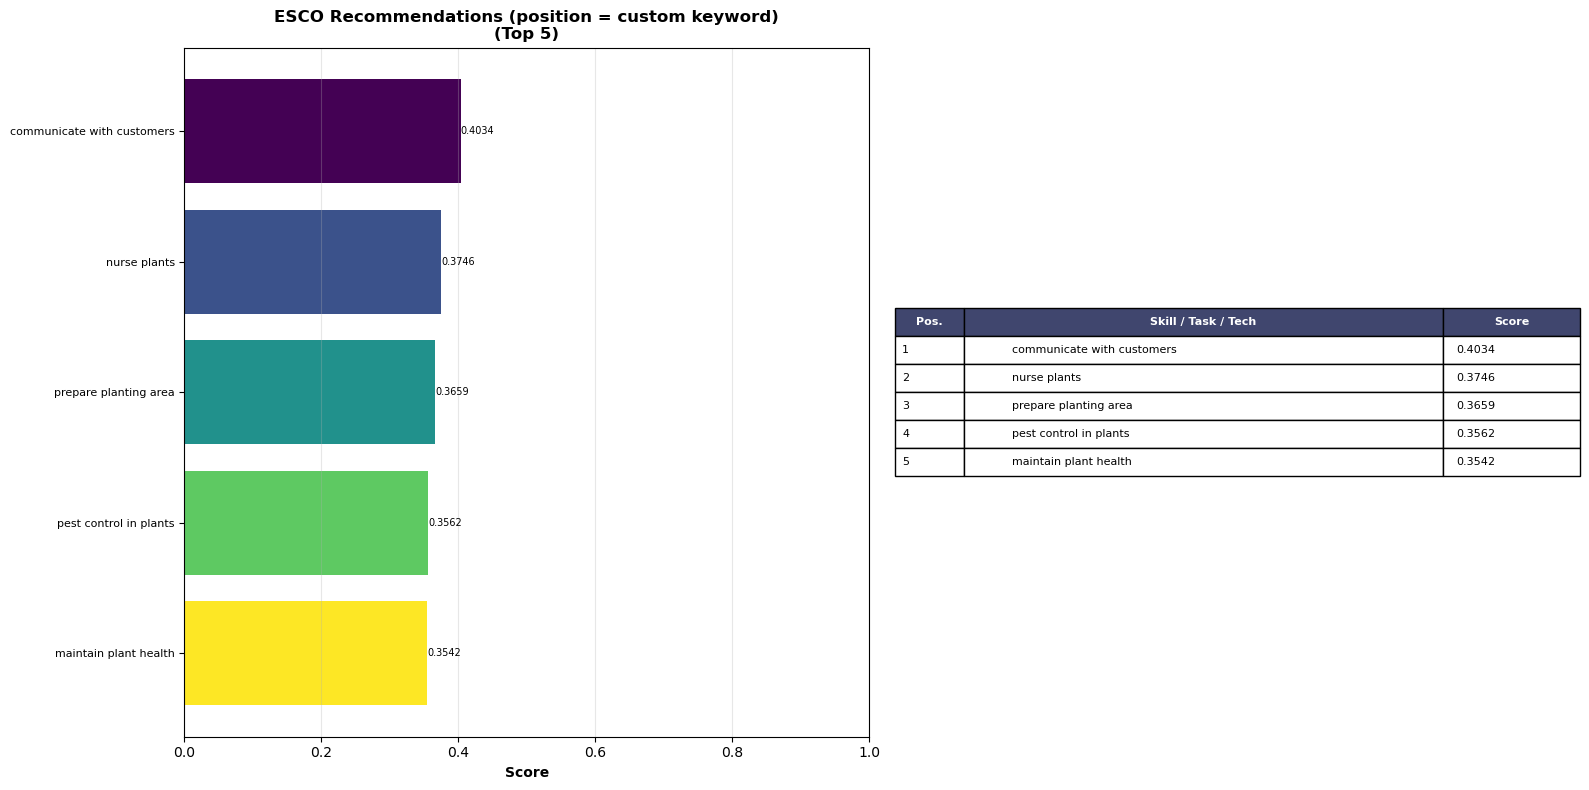


ESCO Recommendations (position = custom keyword)

Top 5 recommendations:

  1. Score:   0.4034 | communicate with customers
  2. Score:   0.3746 | nurse plants
  3. Score:   0.3659 | prepare planting area
  4. Score:   0.3562 | pest control in plants
  5. Score:   0.3542 | maintain plant health


In [23]:
# Custom ESCO: skills whose title contains a keyword (position = these skills)
keyword = "garden"

if 'esco_model' in locals() and (esco_db_path := project_root / "data" / "esco.db").exists():
    conn = sqlite3.connect(str(esco_db_path))
    cursor = conn.cursor()
    cursor.execute("SELECT uri, title FROM esco_skill WHERE language = 'en'")
    skill_id_to_name = {row[0]: row[1] for row in cursor.fetchall()}
    
    cursor.execute("""
        SELECT DISTINCT sk.uri
        FROM esco_occupation_skill rel
        INNER JOIN esco_skill sk ON rel.skill_id = sk.id
        WHERE sk.language = 'en' AND LOWER(sk.title) LIKE ?
        ORDER BY sk.uri
        LIMIT 4
    """, (f"%{keyword}%",))
    rows = cursor.fetchall()
    custom_esco_skills = [r[0] for r in rows]
    conn.close()
    
    print(f"Custom ESCO skills (keyword '{keyword}', n={len(custom_esco_skills)}):")
    for uri in custom_esco_skills:
        print(f"  {skill_id_to_name.get(uri, '?')}")
    
    custom_recommendations = recommend_skills(
        model_data=esco_model,
        input_skill_uris=custom_esco_skills,
        top_k=5,
        filter_existing=True
    )
    
    visualize_recommendations(
        custom_recommendations,
        title="ESCO Recommendations (position = custom keyword)",
        top_k=5,
        skill_id_to_name=skill_id_to_name
    )
else:
    print("Load the ESCO model first in section 6.3")

---

## Summary

This notebook has run:
1. Environment setup and folder creation
2. O*NET data download (automatic)
3. O*NET and ESCO database import
4. WALS model training (ESCO; O*NET task + technology skill)
5. Position-based recommendations with visualizations

**Generated files:**
- `data/onet.db` - O*NET database (occupations, tasks, technology skills)
- `data/esco.db` - ESCO database
- `models/onet_task_wmf_model.pkl` - O*NET task model
- `models/onet_tech_skill_wmf_model.pkl` - O*NET technology skill model
- `models/esco_wmf_model_en.pkl` - ESCO model

**Next steps:**
- Use the models for custom position-based recommendations
- Integrate the models into other systems
- Experiment with different training parameters